In [25]:
# imports and loading
import os
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import parameter_optimization as po
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\SBRG_2024\AppData\Local\Temp\ipykernel_12424\922400818.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
C:\Users\SBRG_2024\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\SBRG_2024\AppData\Local\Temp\ipykernel_12424\922400818.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


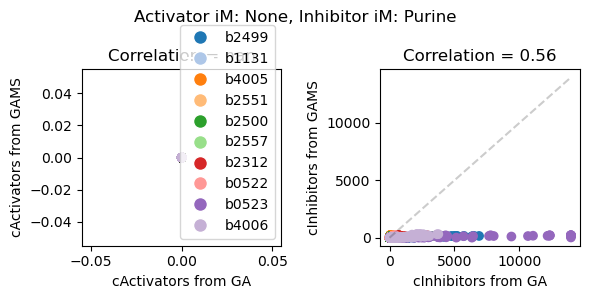

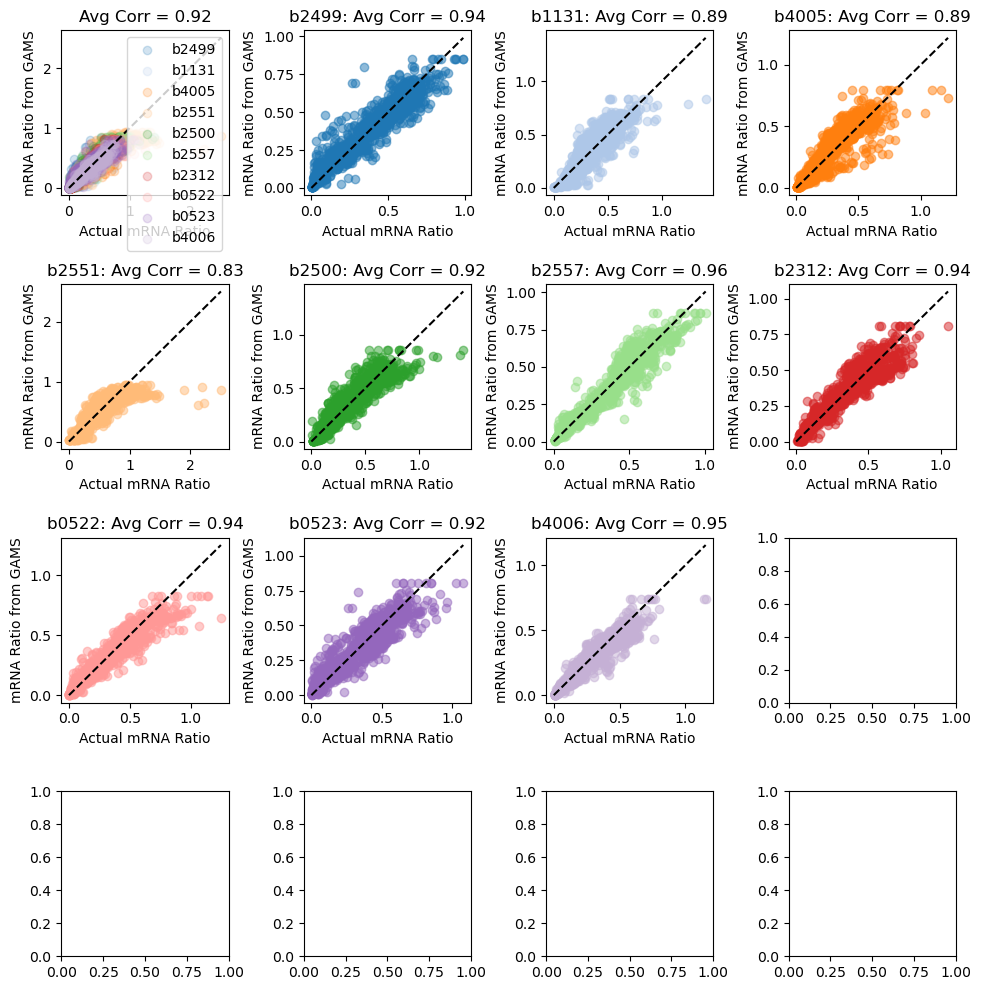

In [26]:
# read and display GAMs

# settings
iMs_run = ['Purine']#Crp-2', 'DhaR', 'Fatty Acid', 'BasR', 'Purine']#, 'Fatty Acid', 'BasR', 'Purine']#, 'Purine', 'Fatty Acid']
case = '___'.join(iMs_run).replace(' ', '_')
clustering = False
scale_to_100_perc = True # scale cAct / cInh by 100%

if True:

    # pull in flags_df and limit to iMs listed
    flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)
    flags_df = flags_df[flags_df['include'] == True]
    true_false = []
    for act, inh in zip(flags_df['act_iM'], flags_df['inh_iM']):
        if act in iMs_run or inh in iMs_run:
            true_false.append(True)
        else:
            true_false.append(False)
    flags_df = flags_df.loc[true_false]

    iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
    run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
    GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
    GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    
    # load in
    iM_saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cAct_vals.csv', index_col = 0)
    iM_saved_cInhibitors = pd.read_csv(GAMs_run_dir+'/input_files/composite_cInh_vals.csv', index_col = 0)
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)

    # loop through all iM pairs
    act_inh_iM_pairs = [(act, inh) for act, inh in zip(flags_df.act_iM, flags_df.inh_iM)]
    for act_iM, inh_iM in set(act_inh_iM_pairs):
        # check that they both exist
        disp_act_iM = act_iM
        disp_inh_iM = inh_iM
        if type(act_iM) == float:
            act_iM = inh_iM # this will correctly pull zero values to fill in
            disp_act_iM = 'None'
        elif type(inh_iM) == float:
            inh_iM = act_iM
            disp_inh_iM = 'None'

        # grab genes
        g1 = cAct_mapping[cAct_mapping[act_iM] != 0].index.to_list()
        g2 = cInh_mapping[cInh_mapping[inh_iM] != 0].index.to_list()
        genes = list(set(g1).union(g2))

        # load in for loop
        calc_cAct = GAMS_calc_cAct[genes]
        calc_cInh = GAMS_calc_cInh[genes]
        saved_cActivators = iM_saved_cActivators[iM_saved_cActivators['iM'] == act_iM].drop(columns = 'iM').loc[genes]
        saved_cInhibitors = iM_saved_cInhibitors[iM_saved_cInhibitors['iM'] == inh_iM].drop(columns = 'iM').loc[genes]

        # plotting
        saved = []
        calc = []
        labels = []
        gene_to_color = {}
        cmap = cm.get_cmap('tab20')
        color_opts = iter(cmap.colors)
        colors = []
        for gene in calc_cAct.columns:
            if gene not in gene_to_color:
                gene_to_color.update({gene : next(color_opts)})
            color = gene_to_color[gene]
            for sample in calc_cAct.index:
                if scale_to_100_perc:
                    saved.append(saved_cActivators[sample].loc[gene] / max(saved_cActivators.loc[gene]))
                    calc.append(calc_cAct.loc[sample][gene] / max(calc_cAct[gene]))
                else:
                    saved.append(saved_cActivators[sample].loc[gene])
                    calc.append(calc_cAct.loc[sample][gene])
                labels.append(gene+', '+sample)
                colors.append(color)
        fig, axs = plt.subplots(1, 2, figsize = (6, 3))
        scatter = axs[0].scatter(saved, calc, c = colors)
        if scale_to_100_perc:
            axs[0].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
        else:
            axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
        if scale_to_100_perc:
            axs[0].set_xlabel('cActivators from GA (%age of max)')
            axs[0].set_ylabel('cActivators from GAMS (%age of max)')
        else:
            axs[0].set_xlabel('cActivators from GA')
            axs[0].set_ylabel('cActivators from GAMS')
        corr = np.corrcoef(saved, calc)

        axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
        #plt.yscale('log')
        #plt.xscale('log')

        # Create an empty list to store legend handles and labels
        legend_elements = []
        for label, color in gene_to_color.items():
            legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
        axs[0].legend(handles = legend_elements, loc = 'lower right')


        # now plot cInhibitor

        # plotting
        saved = []
        calc = []
        labels = []
        gene_to_color = {}
        cmap = cm.get_cmap('tab20')
        color_opts = iter(cmap.colors)
        colors = []
        for gene in calc_cInh.columns:
            if gene not in gene_to_color:
                gene_to_color.update({gene : next(color_opts)})
            color = gene_to_color[gene]
            for sample in calc_cInh.index:
                if scale_to_100_perc:
                    saved.append(saved_cInhibitors[sample].loc[gene] / max(saved_cInhibitors.loc[gene]))
                    calc.append(calc_cInh.loc[sample][gene] / max(calc_cInh[gene]))
                else:
                    saved.append(saved_cInhibitors[sample].loc[gene])
                    calc.append(calc_cInh.loc[sample][gene])
                labels.append(gene+', '+sample)
                colors.append(color)
        scatter = axs[1].scatter(saved, calc, c = colors)
        if scale_to_100_perc:
            axs[1].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
        else:
            axs[1].plot([0, max(saved_cInhibitors.values.flatten())], [0, max(saved_cInhibitors.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
        if scale_to_100_perc:
            axs[1].set_xlabel('cInhibitors from GA (%age of max)')
            axs[1].set_ylabel('cInhibitors from GAMS (%age of max)')
        else:
            axs[1].set_xlabel('cInhibitors from GA')
            axs[1].set_ylabel('cInhibitors from GAMS')
        corr = np.corrcoef(saved, calc)
        axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
        #plt.yscale('log')
        #plt.xscale('log')
        fig.suptitle('Activator iM: '+disp_act_iM+', Inhibitor iM: '+disp_inh_iM)
        fig.tight_layout()
        plt.savefig('../figures/GAMS_cAct_cInh_results.pdf', transparent = True)
        plt.show()

        # I need recreated cActivators and cInhibitors
        gene_to_groups = {}
        colors = iter(plt.cm.tab20.colors)
        all_shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
        corrs = []
        recons_mRNAs = []
        actual_mRNAs = []
        indices_for_recons = []
        max_mRNA = 0
        dims = int(np.sqrt(len(calc_cAct.columns)))+1
        fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
        axs = axs.flatten()
        #plt.figure(figsize = (4, 4))
        g_ct = 1
        grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
        ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
        for gene in calc_cAct.columns:
            shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)).intersection(ratios_df.index[ratios_df[gene].notnull()]))

            actual_mRNAs.append(ratios_df.loc[shared][gene])
            # setup
            #po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))
            pickle_in = open('../data/lambda_dfs/'+gene+'.pkl', 'rb')
            lambda_df = pickle.load(pickle_in)
            pickle_in.close()

            recon_mRNA = []
            for sample in shared:
                cAct = calc_cAct[gene].loc[sample]
                cInh = calc_cInh[gene].loc[sample]
                lambda_df1 = lambda_df[gene].loc[sample]
                recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp'], lambda_df_input = lambda_df1))
            recons_mRNAs.append(recon_mRNA)
            indices_for_recons.append(gene)

            actual_mRNA = ratios_df.loc[shared][gene].values.flatten()
            if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
                max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
            max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

            corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
            corrs.append(corr[0][1])
            c = next(colors)
            axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.2)

            if clustering:
                # leaving this DBSCAN and kmeans stuff here in case it's useful later
                if False:
                    cluster = DBSCAN(eps=2, min_samples=2) # KMeans(n_clusters=k)
                    data = np.column_stack((actual_mRNA, recon_mRNA))
                    cluster.fit(data)
                    labels = cluster.labels_
                    colors_2 = ['b', 'r']
                    for i in range(len(data)):
                        axs[g_ct].scatter(data[i][0], data[i][1], c = colors_2[labels[i]], alpha = 0.5)

                # I want to find the best fit line that originates at zero, pick all points near to it, and make that a group
                most_pts = 0
                for slope in np.linspace(0, 5, 100):
                    correct = 0
                    for actual, pred in zip(actual_mRNA, recon_mRNA):
                        model_pred = actual * slope
                        if abs(model_pred - pred) < 0.05:
                            correct += 1
                    if correct > most_pts:
                        most_pts = correct
                        best_slope = slope
                colors_2 = ['b', 'r']
                hit = []
                miss = []
                for actual, pred, label in zip(actual_mRNA, recon_mRNA, shared):
                    model_pred = actual * best_slope
                    if abs(model_pred - pred) < 0.05:
                        hit.append(label)
                        color = colors_2[0]
                    else:
                        miss.append(label)
                        color = colors_2[1]
                    axs[g_ct].scatter(actual, pred, c = color, alpha = 0.5)
                hit.sort()
                miss.sort()
                gene_to_groups.update({gene : {'hit' : hit, 'miss' : miss}})

            else:
                axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
            axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
            axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
            axs[g_ct].set_xlabel('Actual mRNA Ratio')
            axs[g_ct].set_ylabel('mRNA Ratio from GAMS')
            g_ct += 1


        axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
        axs[0].legend()
        axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
        axs[0].set_xlabel('Actual mRNA Ratio')
        axs[0].set_ylabel('mRNA Ratio from GAMS')
        plt.tight_layout()
        plt.savefig('../figures/GAMS_mRNA_ratios_results.pdf', transparent = True)
        plt.show()

        # save recon
        recon_df = pd.DataFrame(recons_mRNAs, index = indices_for_recons, columns = all_shared)
        actual_df = pd.DataFrame(actual_mRNAs, index = indices_for_recons, columns = all_shared)

        # display more info on clusters if clustering
        if clustering:
            meas_inh_TF = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)

            # TODO - plot mRNA ratios and MA activity for the clusters, see if you can figure out why they aren't matching up
            # also try plotting any types of inputs they have into the GAMs optimization
            for gene in gene_to_groups.keys():
                hit = gene_to_groups[gene]['hit']
                miss = gene_to_groups[gene]['miss']

                vals_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+gene+'_zerodTrue_mRNA_ratios_and_MA_vals.csv', index_col = 0)
                plt.figure()
                plt.scatter(vals_df.loc[hit]['actual_mRNA_ratio'], vals_df.loc[hit]['MA_inhibitor'], color = 'blue')
                plt.scatter(vals_df.loc[miss]['actual_mRNA_ratio'], vals_df.loc[miss]['MA_inhibitor'], color = 'red')
                plt.xlabel('Actual mRNA Ratio')
                plt.ylabel('MA_inhibitor')
                plt.title(gene)
                plt.show()

                plt.figure()
                plt.scatter(vals_df.loc[hit]['actual_mRNA_ratio'], meas_inh_TF.loc[hit]['b3237'], color = 'blue')
                plt.scatter(vals_df.loc[miss]['actual_mRNA_ratio'], meas_inh_TF.loc[miss]['b3237'], color = 'red')
                plt.xlabel('Actual mRNA Ratio')
                plt.ylabel('Actual TF Conc')
                plt.title(gene)
                plt.show()    